# Keras Seqeuntial Artifical Neural Network (Output: ReLU/Sigmoid Activation) for Market Trading - updated 12/03/2022 ver 2.0

## <i> i.) Import Libraries and Dependencies </i>

In [1]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import os
import re

In [2]:
# Import Keras ANN Modeling Libraries & Sklearn Preprocessing Modules
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset

# Import Keras ANN Dropout & Regularizer Build Processing Modules
# Import dropout
from keras.layers import Dropout
# Import regularizers
from keras.regularizers import l1, l2

2022-12-05 18:55:31.051169: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## <i> ii.) Prepare the DataFrames </i>

In [3]:
# Get filename from dir and store as 'algoData_asset' for each individual asset file to use later in labelling/filenaming
filename = Path("../Datasets/algoData_Gold.csv")

display(os.path.basename(filename))
display(os.path.dirname(filename))
display(os.path.splitext(filename))
display(os.path.splitext(os.path.basename(filename)))
algoData_asset = os.path.splitext(os.path.basename(filename))
algoData_asset = algoData_asset[0] 
algoData_asset = algoData_asset.split('_')
algoData_asset = algoData_asset[1]
print(algoData_asset)

#print(os.path.splitext(filename))

'algoData_Gold.csv'

'../Datasets'

('../Datasets/algoData_Gold', '.csv')

('algoData_Gold', '.csv')

Gold


In [4]:
# Confirm algoData_asset is type(str)
type(algoData_asset)

str

In [5]:
#Import .csv file as dataframe and shift 'ActualReturns' column forward .shift() 
#to re-align to neutral (as the 'Signal' column and 'ActualReturns' are both shifted backed (.shift(-1)) in the raw .csv file

# Import filename & conver to dataframe
df = pd.read_csv(filename, 
                index_col='Date', 
                parse_dates=True,
                infer_datetime_format=True)
display(df.head(3))
display(df.tail(3))

# Create empty dataframe for 'ActualReturns' column and shift(+1) to realign to neutral timeseries index position
actual_returns_shift_df = pd.DataFrame()
actual_returns_shift_df['Norm Actual Returns'] = df['ActualReturns'].shift()

,Ticker,Date.1,Open,High,Low,Close,Volume,ActualReturns,Signal,EMAShort,...,MOMline_normal,ROCline_normal,SMAline_normal,lowerBB_normal,middleBB_normal,upperBB_normal,2stdBB_normal,MACDline_normal,MACDHistogram_normal,MACDSignal_normal
Date,,,,,,,,,,,,,,,,,,,,,
2006-10-23 00:00:00-04:00,Gold,2006-10-23 00:00:00-04:00,579.700012,579.700012,579.700012,579.700012,4,0.008108,1.0,586.479474,...,0.492876,-0.238571,-0.976000,1.026902,0.991483,0.958425,0.011900,-2.403293,2.190011,-4.593304
2006-10-24 00:00:00-04:00,Gold,2006-10-24 00:00:00-04:00,576.500000,576.500000,576.500000,584.400024,501,0.005476,1.0,586.159558,...,3.249396,-0.135250,-0.762000,1.035350,0.999664,0.966355,0.011796,-2.391118,1.761749,-4.152867
2006-10-25 00:00:00-04:00,Gold,2006-10-25 00:00:00-04:00,587.599976,587.599976,587.599976,587.599976,199,0.015657,1.0,586.381161,...,2.412316,-0.088491,-0.822001,1.041042,1.005223,0.971787,0.011711,-2.099063,1.643043,-3.742106


,Ticker,Date.1,Open,High,Low,Close,Volume,ActualReturns,Signal,EMAShort,...,MOMline_normal,ROCline_normal,SMAline_normal,lowerBB_normal,middleBB_normal,upperBB_normal,2stdBB_normal,MACDline_normal,MACDHistogram_normal,MACDSignal_normal
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-26 00:00:00-04:00,Gold,2022-10-26 00:00:00-04:00,1649.800049,1667.000000,1649.800049,1664.000000,89,-0.001983,-1.0,1656.049311,...,-8.201747,0.394267,-2.183999,1.029921,0.999972,0.971715,0.003495,-11.253848,0.941270,-12.195117
2022-10-27 00:00:00-04:00,Gold,2022-10-27 00:00:00-04:00,1660.699951,1660.699951,1660.699951,1660.699951,2298,-0.012705,-1.0,1656.764794,...,-6.841077,0.003105,-1.992002,1.027986,0.998083,0.969870,0.003503,-10.049238,1.716703,-11.765941
2022-10-28 00:00:00-04:00,Gold,2022-10-28 00:00:00-04:00,1661.000000,1661.000000,1638.699951,1639.599976,626,-0.002257,-1.0,1654.124052,...,-4.692597,-0.193054,-2.314001,1.016023,0.986036,0.957768,0.003600,-10.674123,0.873455,-11.547578


In [6]:
actual_returns_shift_df = actual_returns_shift_df.dropna()

In [7]:
display(actual_returns_shift_df)

,Norm Actual Returns
Date,
2006-10-24 00:00:00-04:00,0.008108
2006-10-25 00:00:00-04:00,0.005476
2006-10-26 00:00:00-04:00,0.015657
2006-10-27 00:00:00-04:00,0.002346
2006-10-30 00:00:00-05:00,0.010866
...,...
2022-10-24 00:00:00-04:00,-0.001393
2022-10-25 00:00:00-04:00,0.002487
2022-10-26 00:00:00-04:00,0.006776


In [8]:
# Create list for non-normalized columns to be dropped out if required
%pprint
col_names = list(df.columns.values)
display(col_names)
display(f"Number of unique columns: {len(col_names)}")

Pretty printing has been turned OFF


['Ticker', 'Date.1', 'Open', 'High', 'Low', 'Close', 'Volume', 'ActualReturns', 'Signal', 'EMAShort', 'EMALong', 'RSIline', 'MOMline', 'ROCline', 'SMAline', 'lowerBB', 'middleBB', 'upperBB', '2stdBB', 'MACDline', 'MACDHistogram', 'MACDSignal', 'EMAShort_zscore', 'EMALong_zscore', 'RSIline_zscore', 'MOMline_zscore', 'ROCline_zscore', 'SMAline_zscore', 'lowerBB_zscore', 'middleBB_zscore', 'upperBB_zscore', '2stdBB_zscore', 'MACDline_zscore', 'MACDHistogram_zscore', 'MACDSignal_zscore', 'EMAShort_normal', 'EMALong_normal', 'RSIline_normal', 'MOMline_normal', 'ROCline_normal', 'SMAline_normal', 'lowerBB_normal', 'middleBB_normal', 'upperBB_normal', '2stdBB_normal', 'MACDline_normal', 'MACDHistogram_normal', 'MACDSignal_normal']

'Number of unique columns: 48'

## <i> ii.) Split Data into Training & Test Sets </i>

In [9]:
# Create X features dataframe
# Drop non-normalized & pre-Zscore calculated column values
# Drop all Bear & Bull signals for Elder Ray as they do not apply to forex strategy only
# I.e. 'lowerBB_normal', 'middleBB_normal', 'upperBB_normal', '2stdBB_normal'

must_drop_feat = ['Ticker', 'Date.1']

OHLCV = ['Open', 'High', 'Low', 'Close', 'Volume'] 

standard_feat = ['EMAShort', 'EMALong', 'RSIline', 'MOMline', 'ROCline', 'SMAline', 'lowerBB', \
                 'middleBB', 'upperBB', '2stdBB', 'MACDline', 'MACDHistogram', 'MACDSignal']

normal_feat = ['EMAShort_normal', 'EMALong_normal', 'RSIline_normal', 'MOMline_normal', 'ROCline_normal', \
               'SMAline_normal', 'lowerBB_normal', 'middleBB_normal', 'upperBB_normal', \
               '2stdBB_normal', 'MACDline_normal', 'MACDHistogram_normal', 'MACDSignal_normal']

zscore_feat = ['EMAShort_zscore', 'EMALong_zscore', 'RSIline_zscore', 'MOMline_zscore', 'ROCline_zscore', \
               'SMAline_zscore', 'lowerBB_zscore', 'middleBB_zscore', 'upperBB_zscore', \
               '2stdBB_zscore', 'MACDline_zscore', 'MACDHistogram_zscore', 'MACDSignal_zscore']



X = df.copy()
X = X.drop(columns = zscore_feat)
X = X.drop(columns = standard_feat)
X = X.drop(columns = OHLCV)
X = X.drop(columns = must_drop_feat)
#X = X.drop(columns = normal_feat)
X['ActualReturns'] = actual_returns_shift_df['Norm Actual Returns']
X = X.dropna()
y = X[['Signal']]
X = X.drop(columns = ['Signal'])

display(f"Number of included columns in final X-features: {len(X.columns)}")
display(X)
display(y)

'Number of included columns in final X-features: 14'

,ActualReturns,EMAShort_normal,EMALong_normal,RSIline_normal,MOMline_normal,ROCline_normal,SMAline_normal,lowerBB_normal,middleBB_normal,upperBB_normal,2stdBB_normal,MACDline_normal,MACDHistogram_normal,MACDSignal_normal
Date,,,,,,,,,,,,,,
2006-10-24 00:00:00-04:00,0.008108,-0.319915,-0.332022,6.885734,3.249396,-0.135250,-0.762000,1.035350,0.999664,0.966355,0.011796,-2.391118,1.761749,-4.152867
2006-10-25 00:00:00-04:00,0.005476,0.221603,-0.070395,7.167102,2.412316,-0.088491,-0.822001,1.041042,1.005223,0.971787,0.011711,-2.099063,1.643043,-3.742106
2006-10-26 00:00:00-04:00,0.015657,1.602896,0.616302,7.757313,3.485370,-0.011957,-0.372001,1.056941,1.019944,0.985450,0.011730,-1.112421,2.103748,-3.216169
2006-10-27 00:00:00-04:00,0.002346,1.571685,0.674356,7.773948,2.797009,-0.158775,-0.277999,1.058536,1.021069,0.986164,0.011834,-0.215050,2.400895,-2.615945
2006-10-30 00:00:00-05:00,0.010866,2.329888,1.105885,7.842490,4.409391,0.136994,-0.420000,1.070909,1.031078,0.994104,0.012301,1.008988,2.899946,-1.890959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-24 00:00:00-04:00,-0.001393,-1.133040,-1.603908,7.081090,-11.706601,0.033413,-2.998000,1.020661,0.989099,0.959431,0.003751,-13.817127,-1.520004,-12.297123
2022-10-25 00:00:00-04:00,0.002487,-0.327942,-1.181389,7.548112,-9.802392,0.303989,-2.572000,1.023179,0.992595,0.963787,0.003617,-12.963680,-0.533246,-12.430435
2022-10-26 00:00:00-04:00,0.006776,1.445580,-0.264253,8.372941,-8.201747,0.394267,-2.183999,1.029921,0.999972,0.971715,0.003495,-11.253848,0.941270,-12.195117


,Signal
Date,
2006-10-24 00:00:00-04:00,1.0
2006-10-25 00:00:00-04:00,1.0
2006-10-26 00:00:00-04:00,1.0
2006-10-27 00:00:00-04:00,1.0
2006-10-30 00:00:00-05:00,-1.0
...,...
2022-10-24 00:00:00-04:00,1.0
2022-10-25 00:00:00-04:00,1.0
2022-10-26 00:00:00-04:00,-1.0


In [10]:
# Splitting Datasets Using 145 Week Groupings
# Select trading begin
training_begin = X.index.min()
print(f"Training begin: {training_begin}.")

# Select trading end
# Note: months = 145 for all assets except ETH-USD (months= 14)
# Note: months = 145 for all assets except BTC-USD (months= 70)
training_end = X.index.min() + DateOffset(months = 145)
print(f"Training end: {training_end}.")

X_train = X.loc[training_begin:training_end] 
y_train = y.loc[training_begin:training_end] 

X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Create Dataframe just to hold 'ActualReturns' values for end of calculations
X_ActualReturns = actual_returns_shift_df.loc[training_end:]
                
#Also save a second X_test_aligned_index for final dataframe
X_test_aligned_index = X.loc[training_end:]

Training begin: 2006-10-24 00:00:00-04:00.
Training end: 2018-11-24 00:00:00-04:00.


In [11]:
# Test output y_train
y_train

,Signal
Date,
2006-10-24 00:00:00-04:00,1.0
2006-10-25 00:00:00-04:00,1.0
2006-10-26 00:00:00-04:00,1.0
2006-10-27 00:00:00-04:00,1.0
2006-10-30 00:00:00-05:00,-1.0
...,...
2018-11-16 00:00:00-05:00,1.0
2018-11-19 00:00:00-05:00,-1.0
2018-11-20 00:00:00-05:00,1.0


In [12]:
# Test output y_test
y_test

,Signal
Date,
2018-11-26 00:00:00-05:00,-1.0
2018-11-27 00:00:00-05:00,1.0
2018-11-28 00:00:00-05:00,1.0
2018-11-29 00:00:00-05:00,-1.0
2018-11-30 00:00:00-05:00,1.0
...,...
2022-10-24 00:00:00-04:00,1.0
2022-10-25 00:00:00-04:00,1.0
2022-10-26 00:00:00-04:00,-1.0


In [13]:
# Function to convert all sell signals (-1) to be compatible with the output sigmoid activation function

def convert_neg(y_df):
    for i in (range(len(y_df))):
        if (y_df['Signal'][i] == -1):
            y_df['Signal'][i] = 0
        
    return y_df

In [14]:
y_train.copy()
y_train = convert_neg(y_train)

/Users/chris/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
y_test.copy()
y_test = convert_neg(y_test)

/Users/chris/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
# Re-test output y_train after -1->0 conversion for sigmoid output compatiblity 
y_train

,Signal
Date,
2006-10-24 00:00:00-04:00,1.0
2006-10-25 00:00:00-04:00,1.0
2006-10-26 00:00:00-04:00,1.0
2006-10-27 00:00:00-04:00,1.0
2006-10-30 00:00:00-05:00,0.0
...,...
2018-11-16 00:00:00-05:00,1.0
2018-11-19 00:00:00-05:00,0.0
2018-11-20 00:00:00-05:00,1.0


In [17]:
# Re-test output y_test after -1->0 conversion for sigmoid output compatiblity 
y_test

,Signal
Date,
2018-11-26 00:00:00-05:00,0.0
2018-11-27 00:00:00-05:00,1.0
2018-11-28 00:00:00-05:00,1.0
2018-11-29 00:00:00-05:00,0.0
2018-11-30 00:00:00-05:00,1.0
...,...
2022-10-24 00:00:00-04:00,1.0
2022-10-25 00:00:00-04:00,1.0
2022-10-26 00:00:00-04:00,0.0


In [18]:
# Training & Test Set Dimensions

display(f"X Dataframe shape: {X.shape}.")
display(f"y Dataframe shape: {y.shape}.")
display(f"X_train Dataframe shape: {X_train.shape}.")
display(f"y_train shape: {y_train.shape}.")
display(f"X_test Dataframe shape: {X_test.shape}.")
display(f"y_test shape: {y_test.shape}.")

'X Dataframe shape: (4030, 14).'

'y Dataframe shape: (4030, 1).'

'X_train Dataframe shape: (3040, 14).'

'y_train shape: (3040, 1).'

'X_test Dataframe shape: (990, 14).'

'y_test shape: (990, 1).'

In [19]:
# Convert y_train/y_test dataframe ['Signal'] columns values to array for Keras Sequential fitting 

y_train = y_train['Signal'].values
display(y_train[0:3])
display(y_train[-1])
y_test = y_test['Signal'].values
display(y_test[0:3])
display(y_test[-1])

array([1., 1., 1.])

0.0

array([0., 1., 1.])

0.0

In [20]:
# Finalize the y_train & y_test data into a trainable array
# Reshape into vertical vectors for use in Sequential Model algorithm

#y_train = y_train['Signal'].values.astype("int32")
#y_train = y_train.reshape(-1,1).astype("int32")
y_train = y_train.reshape(-1,1).astype("int32")

#y_test = y_test['Signal'].values.astype("int32")
y_test = y_test.reshape(-1,1).astype("int32")


display((f"Number of final X_test features to run into ANN: {len(X_test.columns)}."))
display(y_train[0:10])
display(y_test[0:10])

'Number of final X_test features to run into ANN: 14.'

array([[1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0]], dtype=int32)

array([[0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0]], dtype=int32)

In [21]:
# Create the StandardScaler instance
X_scaler = StandardScaler()
#X_train_scaled = pd.DataFrame(X_scaler.fit_transform(X_train),columns =X_train.columns)
#X_test_scaled = pd.DataFrame(X_scaler.fit_transform(X_test),columns =X_test.columns)

# Fit the scaler
X_scaler.fit(X_train)

# Scale the data 
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Display X_train_scaled & X_test_scaled shapes
display(f"X_train_scaled shape: {X_train_scaled.shape}")
display(f"X_train_scaled shape: {X_test_scaled.shape}")

'X_train_scaled shape: (3040, 14)'

'X_train_scaled shape: (990, 14)'

## <i> iii.) Constructing the ANN Model Using Sequential Model </i>

### <i> Defining the Input Parameters to the ANN: </i>

In [22]:
# Define the the number of inputs (features) to the model
number_input_features = len(X_train.iloc[0])

# Review the number of features
display(f"Number of input features (N_i): {number_input_features}.")

# Define the number of neurons in the output layer
number_output_neurons = 1
display(f"Number of output features (N_o): {number_output_neurons}.")

# Calculating optimal hidden layer neurons to use per layer (first layer primary)
# (Calculation code frame added by me 11/12/2022)

# N_h: Number of hidden layer neurons
N_h = 0

# N_i: Number of input neurons
N_i = number_input_features
display(f"N_i: {N_i}")

# N_o: Number of output neurons
N_o = number_output_neurons
display(f"N_o: {N_o}")

# N_s: Number of samples in training data set
N_s = len(X_train)
display(f"N_s: {N_s}")

# alpha_: Arbitrary scaler between (2-10)
alpha_ = 6
display(f"alpha_: {alpha_}")

# Calculate the new value of N_h:
print()
N_h = int(round((N_s / (alpha_ * (N_i + N_o))),0))
display(f"Final ideal value of N_h (ideal number of hidden nodes in [minimal] first layer) should be: {N_h}.")

'Number of input features (N_i): 14.'

'Number of output features (N_o): 1.'

'N_i: 14'

'N_o: 1'

'N_s: 3040'

'alpha_: 6'

'Final ideal value of N_h (ideal number of hidden nodes in [minimal] first layer) should be: 34.'

In [23]:
# Define the number of hidden nodes for the first hidden layer
#hidden_nodes_layer1 = N_h

#hidden_nodes_layer1 = N_h
hidden_nodes_layer1 = 8
hidden_nodes_layer2 = 8
hidden_nodes_layer3 = 8

# Review the number of hidden nodes in the first layer
display(f"Number of hidden node layers (layer 1): {hidden_nodes_layer1}.")

# Instantiate the Artificial Neural Network 'Sequential' Model

nn = Sequential()

# Add LSTM (Long-short term memory layer)

#nn.add(LSTM(units=10, activation="relu", input_shape=(X_train_scaled.shape[0], X_train_scaled.shape[1])))

# First hidden layer
nn.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(Dense(units=(hidden_nodes_layer2), activation="relu"))

# Third hidden layer
nn.add(Dense(units=(hidden_nodes_layer3), activation="relu"))

# Fourth layer becomes dropout layer
#model.add(Dropout(.2,input_shape=(10,)))
#nn.add(Dropout(.1,input_shape=(number_input_features,)))

# Fifth layer to add regularizer layering to the model
#nn.add(Dense(5, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
nn.add(Dense(units=(14), activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

# Output layer
nn.add(Dense(units=1, activation="sigmoid"))


# Check the structure of the model
nn.summary()

'Number of hidden node layers (layer 1): 8.'

2022-12-05 18:55:48.675859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 120       
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 14)                126       
                                                                 
 dense_4 (Dense)             (None, 1)                 15        
                                                                 
Total params: 405
Trainable params: 405
Non-trainable params: 0
_________________________________________________________________


Fit model on X_train_scaled data
Epoch 1/275
12/12 - 1s - loss: 0.8047 - accuracy: 0.4812 - 1s/epoch - 103ms/step
Epoch 2/275
12/12 - 0s - loss: 0.7938 - accuracy: 0.4901 - 52ms/epoch - 4ms/step
Epoch 3/275
12/12 - 0s - loss: 0.7854 - accuracy: 0.4974 - 43ms/epoch - 4ms/step
Epoch 4/275
12/12 - 0s - loss: 0.7783 - accuracy: 0.5072 - 43ms/epoch - 4ms/step
Epoch 5/275
12/12 - 0s - loss: 0.7721 - accuracy: 0.5115 - 48ms/epoch - 4ms/step
Epoch 6/275
12/12 - 0s - loss: 0.7666 - accuracy: 0.5148 - 65ms/epoch - 5ms/step
Epoch 7/275
12/12 - 0s - loss: 0.7614 - accuracy: 0.5138 - 54ms/epoch - 5ms/step
Epoch 8/275
12/12 - 0s - loss: 0.7566 - accuracy: 0.5161 - 56ms/epoch - 5ms/step
Epoch 9/275
12/12 - 0s - loss: 0.7521 - accuracy: 0.5174 - 59ms/epoch - 5ms/step
Epoch 10/275
12/12 - 0s - loss: 0.7479 - accuracy: 0.5197 - 49ms/epoch - 4ms/step
Epoch 11/275
12/12 - 0s - loss: 0.7440 - accuracy: 0.5197 - 66ms/epoch - 5ms/step
Epoch 12/275
12/12 - 0s - loss: 0.7404 - accuracy: 0.5184 - 56ms/epoch - 5

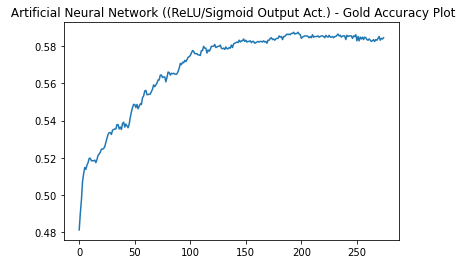

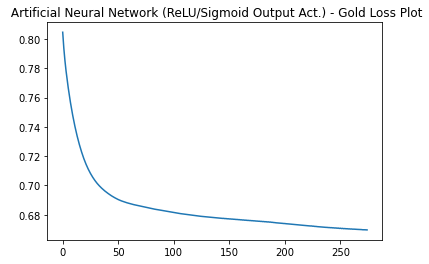

In [24]:
# Compile the Sequential Model
#nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model using 50 epochs and the training data
# 1 epoch = when all samples (images) go through an entire iteration
# batch size = fraction of the entire sample X_train data to be sent through one epoch
# [epoch/batch_size = iterations per epoch] 
# 1 epoch when all samples go through forward/backward iteration

print("Fit model on X_train_scaled data")
fit_model = nn.fit(X_train_scaled, y_train, epochs=275, verbose=2, batch_size=256, shuffle=False)

# Plot the Output of the fit_model history
fig, ax = plt.subplots(1) # Creates figure fig and add an axes, ax.
fig2, ax2 = plt.subplots(1) # Another figure

ax.set_title(f' Artificial Neural Network ((ReLU/Sigmoid Output Act.) - {algoData_asset} Accuracy Plot')
ax.plot(fit_model.history['accuracy'], label='train')
fig.savefig(f'../Datasets/algoData_ANN_model_acc_loss/{algoData_asset}_ann_accuracy_.png')


ax2.set_title(f' Artificial Neural Network (ReLU/Sigmoid Output Act.) - {algoData_asset} Loss Plot')
ax2.plot(fit_model.history['loss'], label='train')
fig2.savefig(f'../Datasets/algoData_ANN_model_acc_loss/{algoData_asset}_ann_loss_.png')

In [25]:
# Evaluate the model using testing data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)

# Display evaluation results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

31/31 - 0s - loss: 0.7090 - accuracy: 0.5202 - 366ms/epoch - 12ms/step
Loss: 0.708967924118042, Accuracy: 0.5202020406723022


In [26]:
# Predict on X_test, y_test datasets

print("Evaluate model on X_test_scaled data")
#predictions = nn.predict(X_test_scaled).astype("int32")
predictions = (nn.predict(X_test_scaled) > 0.51).astype("int32")

Evaluate model on X_test_scaled data
31/31 [==============================] - 0s 2ms/step


In [27]:
display(predictions[0:10])

array([[0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int32)

In [28]:
y_test = y_test.flatten()

In [29]:
results = pd.DataFrame({"predictions": predictions.flatten(), "actual": y_test.flatten()})
#results = pd.DataFrame({"predictions": predictions.ravel(), "actual": y_test}, index=[0])
display(results.value_counts())
display(results.head(10))
display(results.tail(10))

predictions  actual
0            1         286
1            1         261
0            0         241
1            0         202
dtype: int64

,predictions,actual
0,0,0
1,1,1
2,0,1
3,1,0
4,1,1
5,1,1
6,1,0
7,1,1
8,1,0
9,1,0


,predictions,actual
980,0,0
981,0,0
982,1,1
983,0,1
984,0,0
985,0,1
986,0,1
987,0,0
988,0,0
989,1,0


In [30]:
# Function to convert all -1 to 0

def convert_back_to_neg(y_df):
    for i in (range(len(y_df))):
        if (y_df['predictions'][i] == 0):
            y_df['predictions'][i] = -1
        
    return y_df

In [31]:
results.copy()
results = convert_back_to_neg(results)

In [32]:
results

,predictions,actual
0,-1,0
1,1,1
2,-1,1
3,1,0
4,1,1
...,...,...
985,-1,1
986,-1,1
987,-1,0
988,-1,0


In [33]:
results.value_counts()

predictions  actual
-1           1         286
 1           1         261
-1           0         241
 1           0         202
dtype: int64

In [34]:
# Get the original Actual Returns column from the original imported dataset

df_final = df[['ActualReturns']]
df_final = df_final.loc[training_end:]
df_final

,ActualReturns
Date,
2018-11-26 00:00:00-05:00,-0.007376
2018-11-27 00:00:00-05:00,0.008421
2018-11-28 00:00:00-05:00,0.002211
2018-11-29 00:00:00-05:00,-0.003186
2018-11-30 00:00:00-05:00,0.011228
...,...
2022-10-24 00:00:00-04:00,0.002487
2022-10-25 00:00:00-04:00,0.006776
2022-10-26 00:00:00-04:00,-0.001983


In [35]:
# Create function to compile cumulative returns for Artificial Neural Network Predicted y_test values

def annReturns(results, X_test):

    # Make emtpy dataframe to store actual returns, predictions & cumulative returns
    
    # Inititialize first return 0 so cumulative ret begins at base 1
    #annData['Actual Returns'][0] = 0
    
    annData = pd.DataFrame()
    annData.index = X_test.index
    results.index = X_test.index
    annData['Prediction_Signal'] = results['predictions'] 
    annData['Actual_Returns'] = df_final['ActualReturns'].values
    annData['annStrategyReturns'] = annData['Actual_Returns'] * annData['Prediction_Signal'] 
    annData['cumActual_Returns'] = (1 + annData['Actual_Returns']).cumprod()
    annData['cumANNStrategyReturns'] = (1 + annData['annStrategyReturns']).cumprod()
    
    returns = annData
    
    return returns

In [36]:
# Run annReturns Function and display sample final cumulative returns dataframe

returns_df = annReturns(results, X_test)
display(returns_df.head(5))
display(returns_df.tail(5))

,Prediction_Signal,Actual_Returns,annStrategyReturns,cumActual_Returns,cumANNStrategyReturns
Date,,,,,
2018-11-26 00:00:00-05:00,-1,-0.007376,0.007376,0.992624,1.007376
2018-11-27 00:00:00-05:00,1,0.008421,0.008421,1.000984,1.015859
2018-11-28 00:00:00-05:00,-1,0.002211,-0.002211,1.003196,1.013614
2018-11-29 00:00:00-05:00,1,-0.003186,-0.003186,1.000000,1.010384
2018-11-30 00:00:00-05:00,1,0.011228,0.011228,1.011228,1.021729


,Prediction_Signal,Actual_Returns,annStrategyReturns,cumActual_Returns,cumANNStrategyReturns
Date,,,,,
2022-10-24 00:00:00-04:00,-1,0.002487,-0.002487,1.354532,1.303694
2022-10-25 00:00:00-04:00,-1,0.006776,-0.006776,1.363711,1.294859
2022-10-26 00:00:00-04:00,-1,-0.001983,0.001983,1.361006,1.297427
2022-10-27 00:00:00-04:00,-1,-0.012705,0.012705,1.343714,1.313912
2022-10-28 00:00:00-04:00,1,-0.002257,-0.002257,1.340682,1.310947


In [37]:
# Save Results to External .csv File
# Save Finalized Output 'returns_df' dataframe

returns_df.to_csv(f'../Datasets/algoData_ANN_results/{algoData_asset}_ANN_results.csv', index=True)